In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive

In [3]:
# !pip install datasets evaluate transformers
# !pip install accelerate -U
# !pip install transformers[torch]

In [4]:
# !pip install accelerate --upgrade

In [1]:
import numpy as np
import pandas as pd
import os

from datasets import load_dataset, DatasetDict, concatenate_datasets

import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

import matplotlib.pyplot as plt

c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
INPUT_DIR = "./"
OUTPUT_DIR = "./output/bert"
CHECKPOINT = "google-bert/bert-base-multilingual-uncased"

In [3]:
# Load data
data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "train.csv"), trust_remote_code=True, split="train")

data = data.train_test_split(0.2)

translated_data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "translated.csv"), trust_remote_code=True, split="train")

train_data = concatenate_datasets([data['train'], translated_data])
train_data = train_data.shuffle(seed=42)

data = DatasetDict(
    {
        "train": train_data,
        "val": data["test"],
        "test": load_dataset("csv", data_files=os.path.join(INPUT_DIR, "test.csv"), trust_remote_code=True, split="train"),
    }
)
data

# # Load data
# data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "train.csv"), trust_remote_code=True, split="train")

# data = data.train_test_split(0.2)

# data = DatasetDict(
#     {
#         "train": data["train"],
#         "val": data["test"],
#         "test": load_dataset("csv", data_files=os.path.join(INPUT_DIR, "test.csv"), trust_remote_code=True, split="train"),
#     }
# )
# data

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 105876
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 5195
    })
})

In [4]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=3)
model

import torch
import torch.nn as nn

class CNNCls(nn.Module):
    def __init__(self):
        super(CNNCls, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class CNN3Cls(nn.Module):
    def __init__(self):
        super(CNN3Cls, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=768, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=768, out_channels=512, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class LSTMCls(nn.Module):
    def __init__(self):
        super(LSTMCls, self).__init__()
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # LSTM返回两个元组，(output, (h_n, c_n))
        # output: (batch_size, seq_length, num_directions * hidden_size)
        # h_n: (num_layers * num_directions, batch_size, hidden_size)
        # c_n: (num_layers * num_directions, batch_size, hidden_size)
        output, (h_n, c_n) = self.lstm(x)
        x = self.relu(output)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x

class GRUCls(nn.Module):
    def __init__(self):
        super(GRUCls, self).__init__()
        self.gru = nn.GRU(input_size=768, hidden_size=256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # GRU的输出 (output, h_n)
        output, h_n = self.gru(x)  # output: (batch_size, seq_length, hidden_size)
        x = self.relu(output)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x

class RNNCls(nn.Module):
    def __init__(self):
        super(RNNCls, self).__init__()
        self.rnn = nn.RNN(input_size=768, hidden_size=256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # RNN的输出包括 (output, h_n)
        output, h_n = self.rnn(x)  # output: (batch_size, seq_length, hidden_size)
        x = self.relu(output)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x

class MultiheadAttentionCls(nn.Module):
    def __init__(self):
        super(MultiheadAttentionCls, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(768, 3)

    def forward(self, x):
        # 假设x的形状是(batch_size, seq_length, embed_dim)
        # 多头注意力需要输入key, query, value，这里我们使用同一个x作为三者
        attn_output, _ = self.attention(x, x, x)
        # 取多头注意力输出的平均或者最后一个时间步的输出
        x = self.relu(attn_output)
        x = self.dropout(x)
        x = self.fc(x)
        return x


from transformers import BertModel

class CustomBERTModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomBERTModel, self).__init__()
        model_name = CHECKPOINT
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_labels)
        )
        self.loss = nn.CrossEntropyLoss()
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.dropout(output.pooler_output)
        logits = self.classifier(output)

        if labels is not None:
            loss = self.loss(logits.view(-1, self.num_labels), labels.view(-1))
            return {"loss": loss, "logits": logits}
        else:
            return logits

# model = CustomBERTModel(num_labels=3)
model.classifier = CNN3Cls()
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [5]:
def preprocess_data(batch):
    batch["text"] = [
        x1 + f" {tokenizer.sep_token} " + x2
        for x1, x2 in zip(batch["premise"], batch["hypothesis"])
    ]
    return tokenizer(batch["text"])

data = data.map(preprocess_data, batched=True)

Map: 100%|██████████| 2424/2424 [00:00<00:00, 22384.99 examples/s]


In [6]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)

train_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "results"),
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    report_to=[],
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    save_steps=200,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=1,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=3,
    save_only_model=True,
)

In [7]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
  3%|▎         | 200/6618 [00:29<14:55,  7.16it/s]

{'loss': 1.0815, 'grad_norm': 11.2739839553833, 'learning_rate': 1.939860985191901e-05, 'epoch': 0.03}


                                                  
  3%|▎         | 200/6618 [00:34<14:55,  7.16it/s]

{'eval_loss': 1.0405302047729492, 'eval_accuracy': 0.4513201320132013, 'eval_runtime': 4.5372, 'eval_samples_per_second': 534.254, 'eval_steps_per_second': 33.501, 'epoch': 0.03}


  6%|▌         | 400/6618 [01:03<13:56,  7.43it/s]  

{'loss': 1.027, 'grad_norm': 6.456549167633057, 'learning_rate': 1.8794197642792388e-05, 'epoch': 0.06}


                                                  
  6%|▌         | 400/6618 [01:08<13:56,  7.43it/s]

{'eval_loss': 0.9902028441429138, 'eval_accuracy': 0.48267326732673266, 'eval_runtime': 4.555, 'eval_samples_per_second': 532.161, 'eval_steps_per_second': 33.37, 'epoch': 0.06}


  9%|▉         | 600/6618 [01:38<14:35,  6.87it/s]  

{'loss': 1.0111, 'grad_norm': 5.547323226928711, 'learning_rate': 1.8192807494711394e-05, 'epoch': 0.09}


                                                  
  9%|▉         | 600/6618 [01:43<14:35,  6.87it/s]

{'eval_loss': 0.9801955819129944, 'eval_accuracy': 0.4900990099009901, 'eval_runtime': 4.466, 'eval_samples_per_second': 542.765, 'eval_steps_per_second': 34.035, 'epoch': 0.09}


 12%|█▏        | 800/6618 [02:13<13:21,  7.26it/s]  

{'loss': 0.9853, 'grad_norm': 6.05389404296875, 'learning_rate': 1.758839528558477e-05, 'epoch': 0.12}


                                                  
 12%|█▏        | 800/6618 [02:17<13:21,  7.26it/s]

{'eval_loss': 0.9579086899757385, 'eval_accuracy': 0.5103135313531353, 'eval_runtime': 4.8499, 'eval_samples_per_second': 499.805, 'eval_steps_per_second': 31.341, 'epoch': 0.12}


 15%|█▌        | 1000/6618 [02:49<13:20,  7.02it/s] 

{'loss': 0.9843, 'grad_norm': 12.963191032409668, 'learning_rate': 1.6983983076458146e-05, 'epoch': 0.15}


                                                   
 15%|█▌        | 1000/6618 [02:53<13:20,  7.02it/s]

{'eval_loss': 0.9530347585678101, 'eval_accuracy': 0.4830858085808581, 'eval_runtime': 4.8686, 'eval_samples_per_second': 497.881, 'eval_steps_per_second': 31.22, 'epoch': 0.15}


 18%|█▊        | 1200/6618 [03:24<12:47,  7.06it/s]  

{'loss': 0.9636, 'grad_norm': 4.176209449768066, 'learning_rate': 1.6379570867331522e-05, 'epoch': 0.18}


                                                   
 18%|█▊        | 1200/6618 [03:29<12:47,  7.06it/s]

{'eval_loss': 0.9146376252174377, 'eval_accuracy': 0.5804455445544554, 'eval_runtime': 4.7366, 'eval_samples_per_second': 511.763, 'eval_steps_per_second': 32.091, 'epoch': 0.18}


 21%|██        | 1400/6618 [04:00<12:18,  7.07it/s]  

{'loss': 0.9477, 'grad_norm': 8.844844818115234, 'learning_rate': 1.5775158658204898e-05, 'epoch': 0.21}


                                                   
 21%|██        | 1400/6618 [04:05<12:18,  7.07it/s]

{'eval_loss': 0.9044820666313171, 'eval_accuracy': 0.566006600660066, 'eval_runtime': 4.6029, 'eval_samples_per_second': 526.624, 'eval_steps_per_second': 33.023, 'epoch': 0.21}


 24%|██▍       | 1600/6618 [04:36<12:20,  6.78it/s]  

{'loss': 0.9233, 'grad_norm': 6.077694892883301, 'learning_rate': 1.5170746449078272e-05, 'epoch': 0.24}


                                                   
 24%|██▍       | 1600/6618 [04:40<12:20,  6.78it/s]

{'eval_loss': 0.9033766984939575, 'eval_accuracy': 0.568069306930693, 'eval_runtime': 4.82, 'eval_samples_per_second': 502.909, 'eval_steps_per_second': 31.536, 'epoch': 0.24}


 27%|██▋       | 1800/6618 [05:11<11:48,  6.80it/s]  

{'loss': 0.9346, 'grad_norm': 5.74880838394165, 'learning_rate': 1.4566334239951647e-05, 'epoch': 0.27}


                                                   
 27%|██▋       | 1800/6618 [05:16<11:48,  6.80it/s]

{'eval_loss': 0.8756827712059021, 'eval_accuracy': 0.5928217821782178, 'eval_runtime': 4.6689, 'eval_samples_per_second': 519.177, 'eval_steps_per_second': 32.556, 'epoch': 0.27}


 30%|███       | 2000/6618 [05:47<11:15,  6.84it/s]  

{'loss': 0.915, 'grad_norm': 7.063924789428711, 'learning_rate': 1.3961922030825024e-05, 'epoch': 0.3}


                                                   
 30%|███       | 2000/6618 [05:51<11:15,  6.84it/s]

{'eval_loss': 0.8630071878433228, 'eval_accuracy': 0.6064356435643564, 'eval_runtime': 4.7151, 'eval_samples_per_second': 514.091, 'eval_steps_per_second': 32.237, 'epoch': 0.3}


 33%|███▎      | 2200/6618 [06:22<10:37,  6.93it/s]  

{'loss': 0.9036, 'grad_norm': 5.634047985076904, 'learning_rate': 1.33575098216984e-05, 'epoch': 0.33}


                                                   
 33%|███▎      | 2200/6618 [06:26<10:37,  6.93it/s]

{'eval_loss': 0.8804119825363159, 'eval_accuracy': 0.5977722772277227, 'eval_runtime': 4.5431, 'eval_samples_per_second': 533.562, 'eval_steps_per_second': 33.458, 'epoch': 0.33}


 36%|███▋      | 2400/6618 [06:56<09:33,  7.35it/s]  

{'loss': 0.8877, 'grad_norm': 7.150135517120361, 'learning_rate': 1.2753097612571774e-05, 'epoch': 0.36}


                                                   
 36%|███▋      | 2400/6618 [07:01<09:33,  7.35it/s]

{'eval_loss': 0.8552906513214111, 'eval_accuracy': 0.6262376237623762, 'eval_runtime': 4.5454, 'eval_samples_per_second': 533.284, 'eval_steps_per_second': 33.44, 'epoch': 0.36}


 39%|███▉      | 2600/6618 [07:31<09:23,  7.13it/s]  

{'loss': 0.8801, 'grad_norm': 10.366392135620117, 'learning_rate': 1.2151707464490783e-05, 'epoch': 0.39}


                                                   
 39%|███▉      | 2600/6618 [07:35<09:23,  7.13it/s]

{'eval_loss': 0.8536328673362732, 'eval_accuracy': 0.6229372937293729, 'eval_runtime': 4.786, 'eval_samples_per_second': 506.481, 'eval_steps_per_second': 31.76, 'epoch': 0.39}


 42%|████▏     | 2800/6618 [08:07<09:18,  6.84it/s]  

{'loss': 0.8807, 'grad_norm': 10.154515266418457, 'learning_rate': 1.1547295255364159e-05, 'epoch': 0.42}


                                                   
 42%|████▏     | 2800/6618 [08:12<09:18,  6.84it/s]

{'eval_loss': 0.8295620679855347, 'eval_accuracy': 0.629950495049505, 'eval_runtime': 4.6707, 'eval_samples_per_second': 518.98, 'eval_steps_per_second': 32.543, 'epoch': 0.42}


 45%|████▌     | 3000/6618 [08:43<08:37,  7.00it/s]  

{'loss': 0.8732, 'grad_norm': 5.3721466064453125, 'learning_rate': 1.0942883046237536e-05, 'epoch': 0.45}


                                                   
 45%|████▌     | 3000/6618 [08:47<08:37,  7.00it/s]

{'eval_loss': 0.8402453064918518, 'eval_accuracy': 0.6241749174917491, 'eval_runtime': 4.7731, 'eval_samples_per_second': 507.841, 'eval_steps_per_second': 31.845, 'epoch': 0.45}


 48%|████▊     | 3200/6618 [09:18<07:56,  7.17it/s]  

{'loss': 0.8672, 'grad_norm': 8.94342041015625, 'learning_rate': 1.033847083711091e-05, 'epoch': 0.48}


                                                   
 48%|████▊     | 3200/6618 [09:23<07:56,  7.17it/s]

{'eval_loss': 0.8140122890472412, 'eval_accuracy': 0.6365511551155115, 'eval_runtime': 5.0496, 'eval_samples_per_second': 480.037, 'eval_steps_per_second': 30.101, 'epoch': 0.48}


 51%|█████▏    | 3400/6618 [09:55<07:18,  7.34it/s]  

{'loss': 0.8481, 'grad_norm': 10.29112434387207, 'learning_rate': 9.734058627984287e-06, 'epoch': 0.51}


                                                   
 51%|█████▏    | 3400/6618 [10:00<07:18,  7.34it/s]

{'eval_loss': 0.8195489645004272, 'eval_accuracy': 0.641914191419142, 'eval_runtime': 4.6828, 'eval_samples_per_second': 517.635, 'eval_steps_per_second': 32.459, 'epoch': 0.51}


 54%|█████▍    | 3600/6618 [10:31<06:38,  7.57it/s]  

{'loss': 0.8295, 'grad_norm': 12.457740783691406, 'learning_rate': 9.129646418857661e-06, 'epoch': 0.54}


                                                   
 54%|█████▍    | 3600/6618 [10:36<06:38,  7.57it/s]

{'eval_loss': 0.8015973567962646, 'eval_accuracy': 0.6588283828382838, 'eval_runtime': 4.9759, 'eval_samples_per_second': 487.151, 'eval_steps_per_second': 30.547, 'epoch': 0.54}


 57%|█████▋    | 3800/6618 [11:07<06:40,  7.03it/s]  

{'loss': 0.828, 'grad_norm': 8.477381706237793, 'learning_rate': 8.525234209731037e-06, 'epoch': 0.57}


                                                   
 57%|█████▋    | 3800/6618 [11:11<06:40,  7.03it/s]

{'eval_loss': 0.7866695523262024, 'eval_accuracy': 0.6571782178217822, 'eval_runtime': 4.7918, 'eval_samples_per_second': 505.866, 'eval_steps_per_second': 31.721, 'epoch': 0.57}


 60%|██████    | 4000/6618 [11:44<06:10,  7.06it/s]  

{'loss': 0.8243, 'grad_norm': 15.528752326965332, 'learning_rate': 7.920822000604413e-06, 'epoch': 0.6}


                                                   
 60%|██████    | 4000/6618 [11:49<06:10,  7.06it/s]

{'eval_loss': 0.7781230807304382, 'eval_accuracy': 0.6674917491749175, 'eval_runtime': 4.7447, 'eval_samples_per_second': 510.889, 'eval_steps_per_second': 32.036, 'epoch': 0.6}


 63%|██████▎   | 4200/6618 [12:21<05:14,  7.69it/s]  

{'loss': 0.7965, 'grad_norm': 13.667017936706543, 'learning_rate': 7.316409791477789e-06, 'epoch': 0.63}


                                                   
 63%|██████▎   | 4200/6618 [12:26<05:14,  7.69it/s]

{'eval_loss': 0.7603070735931396, 'eval_accuracy': 0.6716171617161716, 'eval_runtime': 4.548, 'eval_samples_per_second': 532.979, 'eval_steps_per_second': 33.421, 'epoch': 0.63}


 66%|██████▋   | 4400/6618 [13:02<06:37,  5.58it/s]  

{'loss': 0.804, 'grad_norm': 8.08303165435791, 'learning_rate': 6.711997582351164e-06, 'epoch': 0.66}


                                                   
 66%|██████▋   | 4400/6618 [13:07<06:37,  5.58it/s]

{'eval_loss': 0.7396801114082336, 'eval_accuracy': 0.6848184818481848, 'eval_runtime': 4.8603, 'eval_samples_per_second': 498.732, 'eval_steps_per_second': 31.274, 'epoch': 0.66}


 70%|██████▉   | 4600/6618 [13:46<05:57,  5.64it/s]  

{'loss': 0.7741, 'grad_norm': 10.010130882263184, 'learning_rate': 6.107585373224539e-06, 'epoch': 0.7}


                                                   
 70%|██████▉   | 4600/6618 [13:51<05:57,  5.64it/s]

{'eval_loss': 0.7406293749809265, 'eval_accuracy': 0.6868811881188119, 'eval_runtime': 4.4724, 'eval_samples_per_second': 541.989, 'eval_steps_per_second': 33.986, 'epoch': 0.7}


 73%|███████▎  | 4800/6618 [14:28<07:07,  4.25it/s]

{'loss': 0.7703, 'grad_norm': 24.698972702026367, 'learning_rate': 5.503173164097915e-06, 'epoch': 0.73}


                                                   
 73%|███████▎  | 4800/6618 [14:32<07:07,  4.25it/s]

{'eval_loss': 0.7432446479797363, 'eval_accuracy': 0.6848184818481848, 'eval_runtime': 4.4498, 'eval_samples_per_second': 544.739, 'eval_steps_per_second': 34.159, 'epoch': 0.73}


 76%|███████▌  | 5000/6618 [15:13<05:05,  5.29it/s]

{'loss': 0.7731, 'grad_norm': 17.32279396057129, 'learning_rate': 4.89876095497129e-06, 'epoch': 0.76}


                                                   
 76%|███████▌  | 5000/6618 [15:18<05:05,  5.29it/s]

{'eval_loss': 0.7418676018714905, 'eval_accuracy': 0.6794554455445545, 'eval_runtime': 4.4706, 'eval_samples_per_second': 542.208, 'eval_steps_per_second': 34.0, 'epoch': 0.76}


 79%|███████▊  | 5200/6618 [15:53<03:12,  7.36it/s]

{'loss': 0.7698, 'grad_norm': 16.630653381347656, 'learning_rate': 4.294348745844666e-06, 'epoch': 0.79}


                                                   
 79%|███████▊  | 5200/6618 [15:57<03:12,  7.36it/s]

{'eval_loss': 0.7164223790168762, 'eval_accuracy': 0.6988448844884488, 'eval_runtime': 4.4009, 'eval_samples_per_second': 550.798, 'eval_steps_per_second': 34.538, 'epoch': 0.79}


 82%|████████▏ | 5400/6618 [16:38<03:03,  6.65it/s]

{'loss': 0.7732, 'grad_norm': 9.53226375579834, 'learning_rate': 3.6899365367180417e-06, 'epoch': 0.82}


                                                   
 82%|████████▏ | 5400/6618 [16:43<03:03,  6.65it/s]

{'eval_loss': 0.7125309109687805, 'eval_accuracy': 0.7013201320132013, 'eval_runtime': 4.4772, 'eval_samples_per_second': 541.407, 'eval_steps_per_second': 33.95, 'epoch': 0.82}


 85%|████████▍ | 5600/6618 [17:22<02:57,  5.72it/s]

{'loss': 0.7721, 'grad_norm': 11.090963363647461, 'learning_rate': 3.0855243275914177e-06, 'epoch': 0.85}


                                                   
 85%|████████▍ | 5600/6618 [17:27<02:57,  5.72it/s]

{'eval_loss': 0.7218948006629944, 'eval_accuracy': 0.6992574257425742, 'eval_runtime': 4.5872, 'eval_samples_per_second': 528.429, 'eval_steps_per_second': 33.136, 'epoch': 0.85}


 88%|████████▊ | 5800/6618 [18:08<02:21,  5.78it/s]

{'loss': 0.7608, 'grad_norm': 18.10426902770996, 'learning_rate': 2.481112118464793e-06, 'epoch': 0.88}


                                                   
 88%|████████▊ | 5800/6618 [18:12<02:21,  5.78it/s]

{'eval_loss': 0.7147026062011719, 'eval_accuracy': 0.7046204620462047, 'eval_runtime': 4.397, 'eval_samples_per_second': 551.289, 'eval_steps_per_second': 34.569, 'epoch': 0.88}


 91%|█████████ | 6000/6618 [18:51<01:37,  6.34it/s]

{'loss': 0.7596, 'grad_norm': 13.969734191894531, 'learning_rate': 1.8766999093381687e-06, 'epoch': 0.91}


                                                   
 91%|█████████ | 6000/6618 [18:55<01:37,  6.34it/s]

{'eval_loss': 0.7121822834014893, 'eval_accuracy': 0.6889438943894389, 'eval_runtime': 4.603, 'eval_samples_per_second': 526.615, 'eval_steps_per_second': 33.022, 'epoch': 0.91}


 94%|█████████▎| 6200/6618 [19:33<01:08,  6.09it/s]

{'loss': 0.7559, 'grad_norm': 12.526548385620117, 'learning_rate': 1.2722877002115445e-06, 'epoch': 0.94}


                                                   
 94%|█████████▎| 6200/6618 [19:39<01:08,  6.09it/s]

{'eval_loss': 0.7064329981803894, 'eval_accuracy': 0.7033828382838284, 'eval_runtime': 5.4036, 'eval_samples_per_second': 448.592, 'eval_steps_per_second': 28.13, 'epoch': 0.94}


 97%|█████████▋| 6400/6618 [20:18<00:49,  4.43it/s]

{'loss': 0.718, 'grad_norm': 10.69846248626709, 'learning_rate': 6.678754910849201e-07, 'epoch': 0.97}


                                                   
 97%|█████████▋| 6400/6618 [20:23<00:49,  4.43it/s]

{'eval_loss': 0.7166551351547241, 'eval_accuracy': 0.695957095709571, 'eval_runtime': 4.4716, 'eval_samples_per_second': 542.083, 'eval_steps_per_second': 33.992, 'epoch': 0.97}


100%|█████████▉| 6600/6618 [21:00<00:02,  6.06it/s]

{'loss': 0.7541, 'grad_norm': 18.115921020507812, 'learning_rate': 6.346328195829556e-08, 'epoch': 1.0}


                                                   
100%|█████████▉| 6600/6618 [21:04<00:02,  6.06it/s]

{'eval_loss': 0.7133235931396484, 'eval_accuracy': 0.7025577557755776, 'eval_runtime': 4.4669, 'eval_samples_per_second': 542.663, 'eval_steps_per_second': 34.028, 'epoch': 1.0}


100%|██████████| 6618/6618 [21:08<00:00,  5.22it/s]

{'train_runtime': 1268.9037, 'train_samples_per_second': 83.439, 'train_steps_per_second': 5.216, 'train_loss': 0.8595608101398357, 'epoch': 1.0}


TrainOutput(global_step=6618, training_loss=0.8595608101398357, metrics={'train_runtime': 1268.9037, 'train_samples_per_second': 83.439, 'train_steps_per_second': 5.216, 'train_loss': 0.8595608101398357, 'epoch': 1.0})

In [9]:
log = trainer.state.log_history
log

[{'loss': 1.0815,
  'grad_norm': 11.2739839553833,
  'learning_rate': 1.939860985191901e-05,
  'epoch': 0.03,
  'step': 200},
 {'eval_loss': 1.0405302047729492,
  'eval_accuracy': 0.4513201320132013,
  'eval_runtime': 4.5372,
  'eval_samples_per_second': 534.254,
  'eval_steps_per_second': 33.501,
  'epoch': 0.03,
  'step': 200},
 {'loss': 1.027,
  'grad_norm': 6.456549167633057,
  'learning_rate': 1.8794197642792388e-05,
  'epoch': 0.06,
  'step': 400},
 {'eval_loss': 0.9902028441429138,
  'eval_accuracy': 0.48267326732673266,
  'eval_runtime': 4.555,
  'eval_samples_per_second': 532.161,
  'eval_steps_per_second': 33.37,
  'epoch': 0.06,
  'step': 400},
 {'loss': 1.0111,
  'grad_norm': 5.547323226928711,
  'learning_rate': 1.8192807494711394e-05,
  'epoch': 0.09,
  'step': 600},
 {'eval_loss': 0.9801955819129944,
  'eval_accuracy': 0.4900990099009901,
  'eval_runtime': 4.466,
  'eval_samples_per_second': 542.765,
  'eval_steps_per_second': 34.035,
  'epoch': 0.09,
  'step': 600},
 {'

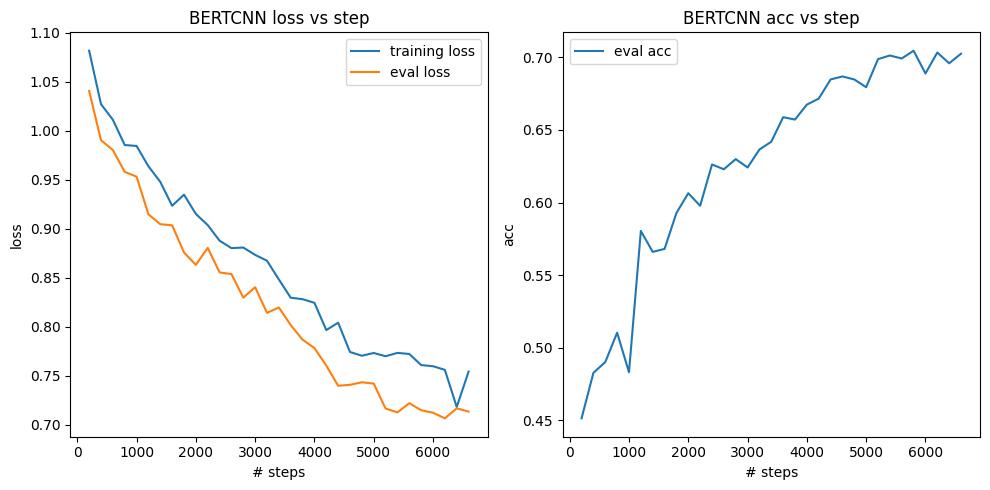

In [10]:
model_name = 'BERTCNN'

steps = []
train_loss = []
eval_loss = []
eval_acc = []

for i in range(0, len(log) - 1, 2):
    train_log = log[i]
    eval_log = log[i + 1]
    steps.append(train_log["step"])
    train_loss.append(train_log["loss"])
    eval_loss.append(eval_log["eval_loss"])
    eval_acc.append(eval_log["eval_accuracy"])

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title(f"{model_name} loss vs step")
plt.xlabel("# steps")
plt.ylabel("loss")
plt.plot(steps, train_loss, label="training loss")
plt.plot(steps, eval_loss, label="eval loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title(f"{model_name} acc vs step")
plt.xlabel("# steps")
plt.ylabel("acc")
plt.plot(steps, eval_acc, label="eval acc")
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
import json


with open(f"{model_name}_aug.json", "w") as f:
    json.dump(
        {
            "steps": steps,
            "train_loss": train_loss,
            "eval_loss": eval_loss,
            "eval_acc": eval_acc,
        },
        f,
        indent=4,
    )

In [ ]:
preds = trainer.predict(data["test"])

In [ ]:
pd.DataFrame(
    {"id": data["test"]["id"], "prediction": np.argmax(preds.predictions, axis=1)}
).to_csv(os.path.join(OUTPUT_DIR, "submission.csv"), header=True, index=False)